This notebook is an attempt to code up the expression for the total change in GW frequency due to gravitational radiation: 

$\Delta f_{\text{gw}} = f_{\text{gw}}(t_0) \left( \left[1 - \frac{256}{5}\mathcal{M}^{5/3}(\pi f)^{8/3}(t_p - t_0)\right]^{-3/8} - 1 \right)$

It was largely unsuccessful, because I keep running into some sort of complex number issue, I think when I'm trying to raise the frequency to 8/3, but I'm not sure? Whatever it is, the changeInFreq function stops working past some value. FrequencyEvolutionApprox contains what I actually used for most of the figures and work I put into the paper/presentation.

Anyway, the point is that there are a lot of functions here that don't do much since they were an experiment, or don't do anything at all because they *don't work*. Not deleted because they're issues I still hope to resolve someday.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from enterprise import constants as const
from matplotlib.colors import LinearSegmentedColormap as linSegColor
import scipy.integrate as integrate

In [2]:
def freqChangeRate(mass, gwFreq): #mass in solar masses, freq in s^-1
    #where freq is the gravitational wave frequency
    freq = gwFreq * np.pi #orbital frequency
    M = mass * 5 * (10 ** -6) # find mass expressed in seconds, rather than solar masses
    dwdt = (-96/5) * (M**(5/3)) * (freq**(11/3))
    return dwdt / np.pi

^ from $\frac{df_{\text{gw}}}{dt} = \frac{96}{5\pi}\mu M^{2/3} \omega^{11/3} = \frac{96}{5\pi} \mathcal{M}^{5/3}\omega^{11/3}$

In [3]:
def changeInFreq(mass, freq, yrs):
    seconds = yrs * 3.154 * (10 ** 7) # convert the years to seconds
    M = mass * 5 * (10 ** -6) # find mass expressed in seconds, rather than solar masses
    inside = ( (1 - (256/5) * (M ** (5/3)) * ( (np.pi * freq) ** (8/3)) * seconds) )
    #print(str(yrs) + ": " + str(inside))
    #val = np.abs(complex(inside) ** (-3/8))
    val = inside ** (-3/8)
    #print(val)
    return (freq * val) - freq

Below is an equivalent of changeInFreq that takes in the non-log versions and calculates everything in log form. I was hoping that this would allow me to sidestep the power issue--after all, you can't get a complex number just by *multiplying* by 3/8, right? I don't remember exactly, but it looks like that didn't end up working.

In [4]:
def logGWFrequencyChange(mass, f, years):
    massSeconds = mass * const.Tsun
    seconds = years * const.yr
    log_t = np.log10(seconds)
    log_f = np.log10(f)
    log_M = np.log10(massSeconds)
    return log_f - (3/8)*( np.log10(256/5) + (5/3) * log_M + (8/3) * np.log10(np.pi) + (8/3) * log_f + log_t)

In [5]:
print("Original: {0}".format(np.log10(changeInFreq(1e9, 1e-9, 1000))))
print("Logarithmic: {0}".format((logGWFrequencyChange(1e9, 1e-9, 1000))))

Original: -13.727139157355419
Logarithmic: -7.383071048988687


Below is some experimenting with how log interacts with units to try and figure out when I should convert between units and when not. For the above function.

In [6]:
def logFirst(mass, frequency):
    logMass = np.log10(mass)
    logSeconds = logMass * const.Tsun
    return (2 * logSeconds) + (3 * np.log10(frequency))

def secondsFirst(mass, frequency):
    massSeconds = mass * const.Tsun
    return (2 * np.log10(massSeconds)) + (3 * np.log10(frequency))
    
def pure(mass, frequency):
    massSeconds = mass * const.Tsun #seconds
    value = massSeconds ** 2 * frequency ** 3 #Hz
    return np.log10(value) #log of Hz

print("Default: {0}".format(pure(1e9, 1e-9)))
print("Log First: {0}".format(logFirst(1e9, 1e-9)))
print("Seconds first: {0}".format(secondsFirst(1e9, 1e-9)))

#seconds first is correct, not log first
#honestly that makes sense, that probably would have been my guess

Default: -19.6151009495307
Log First: -26.999911341162942
Seconds first: -19.6151009495307


from $\Delta \omega = \omega_0 \left[1 - \frac{256}{5}\mathcal{M}^{5/3}\omega_0^{8/3}t\right]^{-3/8} - \omega_0$

which I *believe* maps to $\Delta f = f_0 \left[1 - \frac{256}{5}\mathcal{M}^{5/3}(\pi f)^{8/3}t\right]^{-3/8} - f_0$, but that may be wrong

d log w /dt as a function of log w
y = log w, find diffeq for y (might not be storing values precisely enough)

Below is code for testing some of these functions I guess

In [7]:
testM = 10 ** 9
testFreq = 10 ** -8
expTime = 15
distTime = 1000

print("For 15-year experiment: " + str(changeInFreq(testM, testFreq, expTime)))
print("For 1000 years of travel time: " + str(changeInFreq(testM, testFreq, distTime)))
#by the way, it's exceedingly obnoxious that python doesn't auto-concatenate within print()
#even JAVA auto-concatenates. it seems like the kind of thing python would LOVE to do but noooooo
#dynamic typing? sure! but not when you're obviously trying to print a float, nooooo, we can't have that

#print("Rate of change: " + str(freqChangeRate(testM, testFreq)))

For 15-year experiment: 1.3052922638289102e-12
For 1000 years of travel time: 8.841226634427537e-11


Below is the code for graphing $d\omega/dt$, and it desperately needs to be in log scale. The hope was to eventually draw a version of this that intersected with a similar SS graph. I didn't finish that but did get somewhere pretty close I'll admit

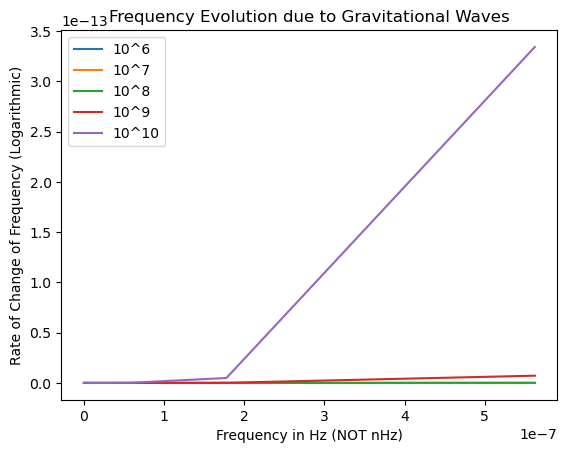

In [15]:
#now we graph dw/dt, which feels less useful but let's graph it anyway, should be quick:
from labellines import labelLine, labelLines

wSamples = []
wInit = (10 ** -0.75) * (10 ** -9) #in hertz
for w in range(8):
    wSamples.append(wInit)
    wInit = wInit * (10 ** 0.5)

masses = [0] * 5
for m in range(11 - 6):
    masses[m] = []
    for w in range(len(wSamples)):
        masses[m].append(-freqChangeRate(10 ** (m + 6), wSamples[w]))

for m in range(11 - 6):
    plt.plot(wSamples, masses[m], label='10^' + str(m + 6))
plt.xlabel("Frequency in Hz (NOT nHz)")
plt.ylabel("Rate of Change of Frequency (Logarithmic)")
plt.title("Frequency Evolution due to Gravitational Waves")
plt.legend()
#ax.set_xticks([1, 10, 100])
#ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

Below is the code for a pulsar class so I can make pulsar objects to handle the pulsar data better, see the pulsar distance distribution notebook for details

In [16]:
class Pulsar:
    def __init__(self, line):
        line = line.split()
        
        self.name = line[0]
        
        temp = line[1].split('+')
        self.meanDistance = float(temp[0])
        temporary = temp[1].split('-')
        self.plusError = float(temporary[0])
        self.minusError = float(temporary[1])
        
        self.rAsc = line[2]
        dividedUp = self.rAsc.split(':')
        hours = float(dividedUp[0])
        minutes = float(dividedUp[1])
        seconds = float(dividedUp[2])
        hours += (minutes / 60) + (seconds / 3600)
        self.phi = np.pi * hours / 12 #THIS IS IN RADIANS; DO WE WANT IT IN RADIANS?
        
        self.dec = line[3]
        divvyUp = self.dec.split(':')
        sign = divvyUp[0][0:1]
        divvyUp[0] = divvyUp[0][1:]
        degrees = float(divvyUp[0])
        minutes = float(divvyUp[1])
        seconds = float(divvyUp[2])
        degrees += (minutes / 60) + (seconds / 3600)
        if (sign.endswith('+')):
            self.theta = (np.pi/2) - (np.pi * degrees / 180)
        else:
            self.theta = (np.pi/2) + (np.pi * degrees / 180)
            
        self.pos = [np.sin(self.phi) * np.cos(self.theta), np.sin(self.phi) * np.sin(self.theta), np.cos(self.phi)]
        
    #can't do multiple constructors? evil evil evil
    
    def __str__(self):
        return "{0}, located at {1} {2}: {3}+{4}-{5} kpc".format(self.name, self.rAsc, self.dec, self.meanDistance, self.plusError, self.minusError)
        #return str(self.name) + ", located at " + str(self.rAsc) + " " + str(self.dec)+": " + str(self.meanDistance) + "+" + str(self.plusError) + "-" + str(self.minusError) + " kpc"
    
    

Below is code to graph the change in frequency of some gravitational wave depending on pulsar distance--you input the starting frequency as baseFreq at the top of the cell. Works for low frequencies; seems to break about 1e-8 Hz. Definitely not exactly the same as linear, although it's very similar for low frequencies. But at 1e-8 you can see the variation.

J0023+0923, located at 00:23:16.87910 +09:23:23.8689: 1.2+0.2-0.2 kpc


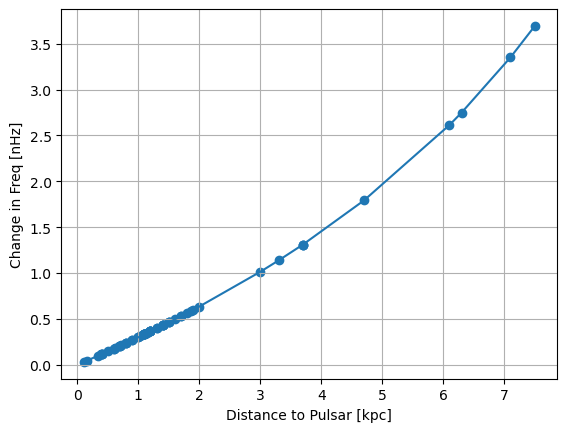

In [17]:
baseM = 10 ** 9 #solar masses
baseFreq = 10 ** -8 #in hertz
#doesn't currently work for higher frequencies, some sort of complex number issue

f = open("pulsarDistPM.txt")
pulsars = []
for x in range(65):
    pulsars.append(Pulsar(f.readline()))
    
print(pulsars[0])
    
distances = np.array([])
for x in range(65):
    distances = np.append(distances, pulsars[x].meanDistance)

times = distances * const.kpc / const.c / const.yr
times = np.sort(times)
distances = np.sort(distances)

changes = []
for x in range(65):
    changes.append(changeInFreq(baseM, baseFreq, times[x]) * (10 ** 9))

truncatedChanges = np.delete(changes, [57, 58, 59, 60, 61, 62, 63, 64])
truncatedDistances = np.delete(distances, [57, 58, 59, 60, 61, 62, 63, 64])
    
plt.scatter(distances, changes)
#plt.scatter(truncatedDistances, truncatedChanges)
plt.plot(distances, changes)
plt.xlabel("Distance to Pulsar [kpc]")
plt.ylabel("Change in Freq [nHz]")
plt.grid()

throws an error if higher than 1e-7.41 I think

Below is a function that was supposed to return the y values for a line showing the cutoff between something detectable and not detectable change in frequency, based on a certain boundary frequency. Did it all in log since the graph would have been in log. (Like, this should have given a black line dividing up the regions for what I used to do in color map form.) It doesn't currently work; it's returning a line that's way too low.

In [18]:
def detectableBoundary(logFreq, yrs, bound):
    #bound in hertz
    #log of frequency in hertz
    seconds = yrs * 3.154 * (10 ** 7) # convert the years to seconds
    freq = 10 ** logFreq
    mx = (-8/3) * logFreq
    b = np.log10( (5/256/seconds) * (1 - ( ((bound + freq)/freq) ** (-8/3)) ) )
    return (3/5) * (mx + b)

from $\frac{5}{3} \log \mathcal{M} = -\frac{8}{3} \log \omega_0 + \log \left(\frac{5}{256t} \left[1 - \left(\frac{2e-9 + \omega_o}{\omega_0}\right)^{-8/3}\right]\right)$

(formula seems to be wrong, come back to and check)

Below is a function that is supposed to return the cutoff for detection based on SNR and period. I was working off a single equation typed into an email by Bence Becsy where variables were not named and latex did not render, so I have no idea if I interpreted it correctly. It also doesn't work because I don't know what's going on in terms of units or scale.

In [19]:
def getBoundary(snr, period):
    #period in seconds
    return (3 ** (1/2)) / (np.pi * period * snr)

^ from: $\sigma_f = \frac{\sqrt{3}}{\pi T \text{SNR}}$

where (I believe)
- $T$ is the period
- $\sigma_f$ is some statistics thing that I'm not sure how to translate into any of my graphs, so for now I will assume it's our desired $\Delta f$
- SNR is signal to noise ratio and this, at least, I'm positive of

Below is the code for a color map that shows the total change in frequency due to GW radiation over 1.5 kpc, and the cutoff boundary for detectability. However, the top right of the graph is missing because my changeInFreq() function has some sort of complex number issue, and my boundary line is too low for reasons I'm not sure of.

/tmp/ipykernel_10451/3637071549.py:7: RuntimeWarning: invalid value encountered in scalar power
  val = inside ** (-3/8)


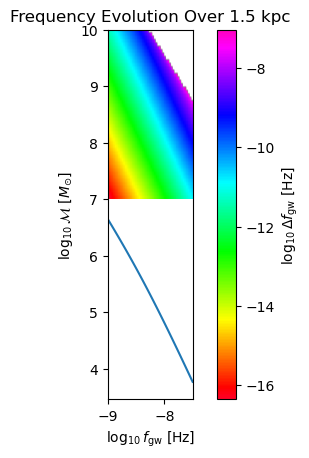

In [20]:
logMSamples = np.linspace(10, 7)
logWSamples = np.linspace(-9, -7.5)
testDist = 1.5
testYears = 3261.56 * testDist
testBound = 2e-9

vals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    vals[M] = []
    for w in range(len(logWSamples)):
        vals[M].append(np.log10(changeInFreq(10 ** logMSamples[M], 10 ** logWSamples[w], testYears)))
    
cutoffMs = []
for x in range(len(logWSamples)):
    cutoffMs.append(detectableBoundary(logWSamples[x], testYears, testBound))
                   
plt.imshow(vals, extent=[-9, -7.5, 7, 10], cmap="gist_rainbow")
plt.colorbar(label=r"$\log_{10} \Delta f_{\text{gw}}$ [Hz]")
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10}\mathcal{M}$ [$M_{\odot}$]")
plt.title("Frequency Evolution Over 1.5 kpc")
plt.plot(logWSamples, cutoffMs)
plt.show()

This matches the distance plot like it's supposed to, as far as I can tell (it's harder to tell here, but it's the same spread of values, just finer)

Below is the code for a color map that shows whether or not the total change in frequency due to GW radiation is detectable. It doesn't seem to be working? It used to be? idk

/tmp/ipykernel_10451/1726604143.py:8: RuntimeWarning: invalid value encountered in log10
  evalues[M].append(np.log10(-changeInFreq(10 ** logMVals[M], 10 ** logWVals[w], 3261.56 * 1.5))) #7.5kpc
/tmp/ipykernel_10451/3637071549.py:7: RuntimeWarning: invalid value encountered in scalar power
  val = inside ** (-3/8)


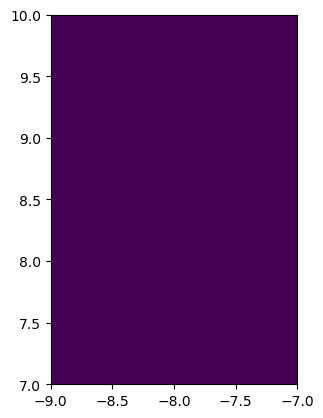

In [22]:
logMVals = np.linspace(10, 7)
logWVals = np.linspace(-9, -7)

evalues = [0] * len(logMVals)
for M in range(len(logMVals)):
    evalues[M] = []
    for w in range(len(logWVals)):
        evalues[M].append(np.log10(-changeInFreq(10 ** logMVals[M], 10 ** logWVals[w], 3261.56 * 1.5))) #1.5kpc

boundaries = [0] * len(logMVals)
for m in range(len(logMVals)):
    boundaries[m] = []
    for w in range(len(logWVals)):
        if evalues[m][w] > -9:
            boundaries[m].append(1)
        else:
            boundaries[m].append(0)


plt.imshow(boundaries, extent=[-9, -7, 7, 10])
plt.show()